In [1]:
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
from skimage import color
from skimage import io
import pandas as pd
from PIL import Image
import collections

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [3]:
def to_index(name):
    return int(name[:6])

In [4]:
def to_name(index):
    name = ''
    for i in range(6 - len(str(index))):
        name += '0'
    name = name + str(index) + '.jpg'
    return name

In [5]:
def load_images_from_folder(folder):
    images = {}
    sizes = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None: 
            sizes[to_index(filename)] = img.size  
            new_img = img.resize((512,512), Image.ANTIALIAS)
            temp = rgb2gray(np.array(new_img))
            images[to_index(filename)] = temp   
    return images, sizes

In [6]:
def change_bbox(name, old_w, old_h, df):
    df.at[to_index(name)-1, 'x_1'] *= (512/old_w)
    df.at[to_index(name)-1, 'y_1'] *= (512/old_h)
    df.at[to_index(name)-1, 'width'] *= (512/old_w)
    df.at[to_index(name)-1, 'height'] *= (512/old_h)

In [7]:
folder_name = './Data/Part 1/first'
train_imgs, old_sizes= load_images_from_folder(folder_name)

In [8]:
od = collections.OrderedDict(sorted(train_imgs.items())) #ordered dict

In [9]:
df = pd.read_csv('Data/list_bbox_celeba.csv')

In [10]:
for i in od.keys():
    img_number = i
    change_bbox(to_name(img_number), old_sizes[img_number][0], old_sizes[img_number][1], df)

In [11]:
def print_img(name):
    x = df.at[to_index(name)-1, 'x_1']
    y = df.at[to_index(name)-1, 'y_1']
    w = df.at[to_index(name)-1, 'width']
    h = df.at[to_index(name)-1, 'height']
    
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(train_imgs[to_index(name)])

    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

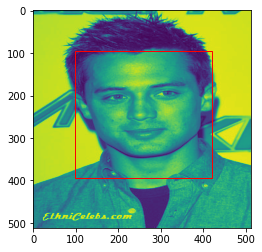

In [12]:
print_img('000007.jpg')

In [13]:
reshaped_list = []
for i in od.keys():
    reshaped_list.append(od[i].reshape(2**18))

In [14]:
from neural_net import TwoLayerNet

In [15]:
net = TwoLayerNet(2**18,20,4)

In [16]:
X_train = np.array(reshaped_list[:200])
X_val = np.array(reshaped_list[200:220])
X_test = np.array(reshaped_list[220:240])
Y_train = np.array(df.drop(columns=['image_id'],axis = 1)[:200])
Y_val = np.array(df.drop(columns=['image_id'],axis = 1)[200:220])
Y_test = np.array(df.drop(columns=['image_id'],axis = 1)[220:240])

262144

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(200, input_dim=X_train.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(Y_train.shape[-1])
    ])
model.compile('adadelta', 'mse')



In [24]:
model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), verbose=2)

Epoch 1/30
7/7 - 18s - loss: 31012.6875 - val_loss: 17262.0332
Epoch 2/30
7/7 - 2s - loss: 22175.3984 - val_loss: 14443.2217
Epoch 3/30
7/7 - 2s - loss: 15297.4062 - val_loss: 19785.8867
Epoch 4/30
7/7 - 2s - loss: 13909.0117 - val_loss: 8202.8350
Epoch 5/30
7/7 - 3s - loss: 11542.5801 - val_loss: 9277.4346
Epoch 6/30
7/7 - 2s - loss: 12203.0713 - val_loss: 7960.5791
Epoch 7/30
7/7 - 2s - loss: 11342.7617 - val_loss: 5742.5225
Epoch 8/30
7/7 - 2s - loss: 8555.7891 - val_loss: 8253.8516
Epoch 9/30
7/7 - 2s - loss: 7658.7627 - val_loss: 8520.2344
Epoch 10/30
7/7 - 2s - loss: 8620.9141 - val_loss: 7722.8618
Epoch 11/30
7/7 - 2s - loss: 7263.4395 - val_loss: 6733.7891
Epoch 12/30
7/7 - 3s - loss: 6688.7471 - val_loss: 5944.0889
Epoch 13/30
7/7 - 2s - loss: 5932.3682 - val_loss: 5406.4131
Epoch 14/30
7/7 - 2s - loss: 5485.3613 - val_loss: 8654.3730
Epoch 15/30
7/7 - 2s - loss: 5617.1631 - val_loss: 6166.7114
Epoch 16/30
7/7 - 2s - loss: 4863.6313 - val_loss: 6461.9658
Epoch 17/30
7/7 - 2s -

In [25]:
pred_y = model.predict(X_test)

In [26]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [31]:
for i in range(0,19):
    sum = IOU(pred_y[i], Y_test[i])
sum = sum/20

In [32]:
sum

0.021639991924496362